In [218]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

from matplotlib import lines as mlines
from multisim import MultiSim
from plotassist.plotlabelmanager import PlotLabelManager
from plotassist.groupedbarplot import GroupedBarPlot
from plotassist.deduplication import deduplicate_legend
from scipy import interpolate

# set plotting style
plt.style.use(['default', 'biophysics.mplstyle'])


In [219]:
# select the data directory
# data_dir = Path('paper_data2/fig1/fig1_true')
# data_dir = Path('paper_data2/fig1/fig1_false')
# data_dir = Path('paper_data2/fig2/fig2_true')
data_dir = Path('paper_data2/fig2/fig2_false')
# data_dir = Path('paper_data2/fig3/fig3_true')
# data_dir = Path('paper_data2/fig3/fig3_false')
# data_dir = Path('paper_data2/fig4/fig4_true')
# data_dir = Path('paper_data2/fig4/fig4_false')

# define and create figure save location
fig_dir = Path('paper_figures') / data_dir.name
fig_dir.mkdir(parents=True, exist_ok=True)
print(f"Saving figures to '{fig_dir}'")

Saving figures to 'paper_figures/fig2_false'


In [220]:
# load simulation data from data folder
multisim = MultiSim(file_dir=data_dir)
print(f"Loaded data from '{data_dir}'")

Loaded data from 'paper_data2/fig2/fig2_false'


In [221]:
# create a simulation averages dataframe for plotting
flen_df = pd.DataFrame([
    {
        'tau_on': sim.get_param('tau_on'),
        'tau_off': sim.get_param('tau_off'),
        'map6_on': sim.get_param('map6_on'),
        'map6_off': sim.get_param('map6_off'),
        'dt': sim.get_param('dt'),
        'fin_len': sim.get_length_at(sim.get_nsteps()-1),
        'tau_frac_tip': sim.get_tau_frac_tip(),
        'map6_frac_tip': sim.get_map6_frac_tip(),
        'tau_frac_length': sim.get_tau_frac_length(),
        'map6_frac_length': sim.get_map6_frac_length(),
        'tau_plus_end_asym': sim.get_tau_plus_end_asym(),
        'map6_plus_end_asym': sim.get_map6_plus_end_asym(),
    }
    for sim in multisim.get_iter()
])

# compute the tau map ratio
# flen_df['tau/map6'] = flen_df['tau_on'] / flen_df['map6_on']

# get a data frame with just columns tau/map, fin_len
# flen_grouped = flen_df[['tau_on', 'fin_len']].groupby('tau/map6')
# for figures 1 and 2
# flen_grouped = flen_df[['tau_on', 'fin_len']].groupby('tau_on')
# for figures 3 and 4
# flen_grouped = flen_df[['map6_on', 'fin_len']].groupby('map6_on')
if 'fig1' in data_dir.name or 'fig2' in data_dir.name:
    flen_grouped = flen_df[['tau_on', 'fin_len']].groupby('tau_on')
else:
    flen_grouped = flen_df[['map6_on', 'fin_len']].groupby('map6_on')

# compute flen stats
flen_stats = pd.DataFrame({
    'mean_fin_len': flen_grouped.mean()['fin_len'],
    'std_fin_len': flen_grouped.std()['fin_len'],
})

# group by the tau map ratio and compute an averages df
# mean_flen_df = flen_df.groupby('tau/map6').mean()
# for figure 1 and 2
# mean_flen_df = flen_df.groupby('tau_on').mean()
# for figure 3 and 4
# mean_flen_df = flen_df.groupby('map6_on').mean()
if 'fig1' in data_dir.name or 'fig2' in data_dir.name:
    mean_flen_df = flen_df.groupby('tau_on').mean()
else:
    mean_flen_df = flen_df.groupby('map6_on').mean()

# get a data frame with just columns tau/map, tau_plus_end_asym, map6_plus_end_asym
asym_df = mean_flen_df[['tau_plus_end_asym', 'map6_plus_end_asym']]
# asym_df.index = asym_df.index.astype(int)

In [222]:
# define the grouped distribution dataframe
# grouped_dist_df = flen_df[['tau/map6', 'tau_frac_tip', 'map6_frac_tip', 'tau_frac_length', 'map6_frac_length']].groupby('tau/map6')
# for figures 1 and 2
# grouped_dist_df = flen_df[['tau_on', 'tau_frac_tip', 'map6_frac_tip', 'tau_frac_length', 'map6_frac_length']].groupby('tau_on')
# for figures 3 and 4
# grouped_dist_df = flen_df[['map6_on', 'tau_frac_tip', 'map6_frac_tip', 'tau_frac_length', 'map6_frac_length']].groupby('map6_on')
# check if figures 1 or 2
if 'fig1' in data_dir.name or 'fig2' in data_dir.name:
    grouped_dist_df = flen_df[['tau_on', 'tau_frac_tip', 'map6_frac_tip', 'tau_frac_length', 'map6_frac_length']].groupby('tau_on')
else:
    grouped_dist_df = flen_df[['map6_on', 'tau_frac_tip', 'map6_frac_tip', 'tau_frac_length', 'map6_frac_length']].groupby('map6_on')

grouped_dist_stats = pd.DataFrame({
    'mean_tau_frac_tip': grouped_dist_df.mean()['tau_frac_tip'],
    'std_tau_frac_tip': grouped_dist_df.std()['tau_frac_tip'],
    'mean_map6_frac_tip': grouped_dist_df.mean()['map6_frac_tip'],
    'std_map6_frac_tip': grouped_dist_df.std()['map6_frac_tip'],
    'mean_tau_frac_len': grouped_dist_df.mean()['tau_frac_length'],
    'std_tau_frac_len': grouped_dist_df.std()['tau_frac_length'],
    'mean_map6_frac_len': grouped_dist_df.mean()['map6_frac_length'],
    'std_map6_frac_len': grouped_dist_df.std()['map6_frac_length'],
})

In [223]:
# define interpolator function
def plot_interpolated_curve(ax, x, y, color, label=None,):
    # Ensure the data is sorted by x (required for interpolation)
    sorted_indices = np.argsort(x)
    x_sorted = np.array(x)[sorted_indices]
    y_sorted = np.array(y)[sorted_indices]

    # Create the interpolator
    interpolator = interpolate.PchipInterpolator(x_sorted, y_sorted)

    # Generate a smooth range of x values
    x_smooth = np.linspace(min(x_sorted), max(x_sorted), 500)
    y_smooth = interpolator(x_smooth)

    # Plot the interpolated curve
    ax.plot(x_smooth, y_smooth, color=color, linestyle='--')

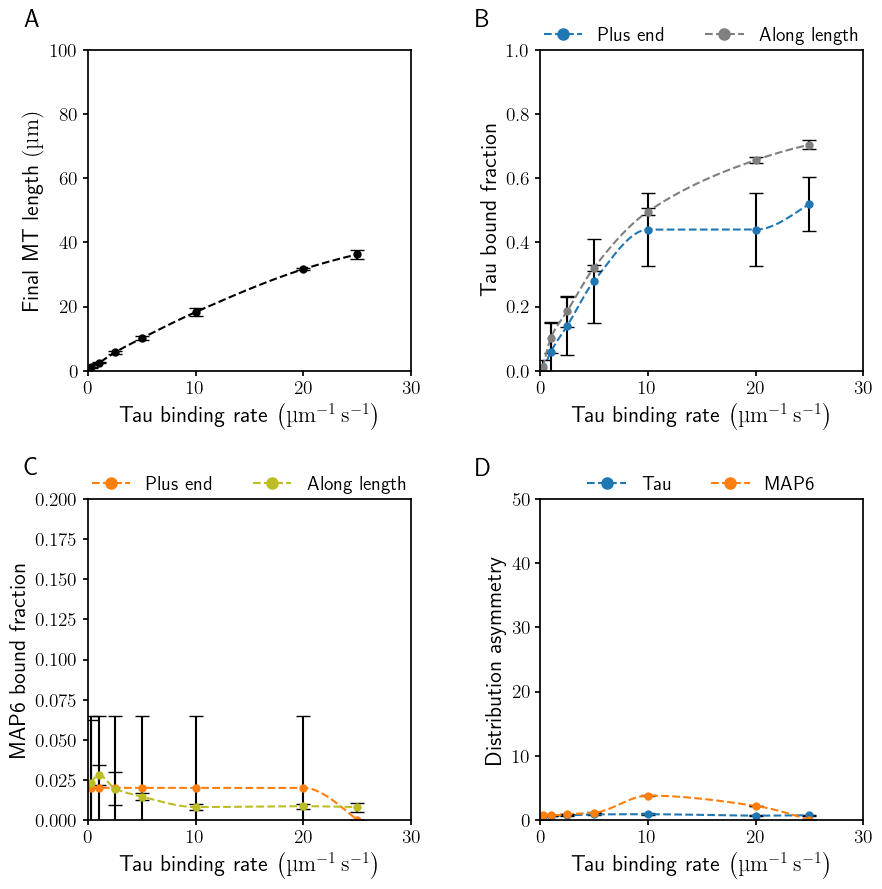

In [224]:
# create a figure with four plots
fig, ((axA, axB), (axC, axD)) = plt.subplots(2, 2, figsize=(10, 10))
axs = [axA, axB, axC, axD]

# increase the spacing between the plots, and do not show
plt.subplots_adjust(hspace=0.4, wspace=0.4)
# margin = 0.25

# label the plots A, B, C, and D
for i, label in enumerate(['A', 'B', 'C', 'D']):
    axs[i].text(-0.2, 1.125, label, transform=axs[i].transAxes, fontsize=18, fontweight='bold', va='top')

    # for figures 1 and 2
    # axs[i].set_xlabel(r"Tau binding rate $\left(\qty{}{\per\micro\meter\per\second}\right)$")

    # for figures 3 and 4
    # axs[i].set_xlabel(r"MAP6 binding rate $\left(\qty{}{\per\micro\meter\per\second}\right)$")

    if 'fig1' in data_dir.name or 'fig2' in data_dir.name:
        axs[i].set_xlabel(r"Tau binding rate $\left(\qty{}{\per\micro\meter\per\second}\right)$")
    else:
        axs[i].set_xlabel(r"MAP6 binding rate $\left(\qty{}{\per\micro\meter\per\second}\right)$")

    # OLD
    # for figures 1
    # axs[i].set_xlim(0, 1000)
    # axs[i].set_xticks([0, 500, 1000])

    # for figure 2
    # axs[i].set_xlim(0-margin, 10+margin)
    # axs[i].set_xticks([0, 50, 100])

    # for figure 3 and 4
    # axs[i].set_xlim(0, 1)
    # axs[i].set_xticks([0, 0.5, 1])

    # NEW
    # for figure 1
    # axs[i].set_xlim(0, 300)
    # axs[i].set_xticks([0, 50, 100, 150, 200, 250, 300])

    # for figures 2, 3, and 4
    # axs[i].set_xlim(0, 30)
    # axs[i].set_xticks([0, 10, 20, 30])

    if 'fig1' in data_dir.name:
        axs[i].set_xlim(0, 300)
        axs[i].set_xticks([0, 50, 100, 150, 200, 250, 300])
    else:
        axs[i].set_xlim(0, 30)
        axs[i].set_xticks([0, 10, 20, 30])


# set the y-axis plot labels
axA.set_ylabel(r"Final MT length $\left(\qty{}{\micro\meter}\right)$")
axB.set_ylabel(r"Tau bound fraction")
axC.set_ylabel(r"MAP6 bound fraction")
axD.set_ylabel(r"Distribution asymmetry")


# plot A
# plot the final MT length in black with error bars for standard error
axA_len_x = flen_stats.index
axA_len_y = flen_stats['mean_fin_len']
axA.errorbar(
    axA_len_x,
    axA_len_y,
    yerr=flen_stats['std_fin_len'],
    fmt='o',
    capsize=5,
    markersize=5,
    label="MT length",
    color='black'
)
plot_interpolated_curve(axA, axA_len_x, axA_len_y, color='black')

# set the y-limits
axA.set_ylim(0, 100)


# plot B
# plot the tau bound fraction
# plus end
axB_plus_x = grouped_dist_stats.index
axB_plus_y = grouped_dist_stats['mean_tau_frac_tip']
axB.errorbar(
    axB_plus_x,
    axB_plus_y,
    yerr=grouped_dist_stats['std_tau_frac_tip'],
    fmt='o',
    capsize=5,
    markersize=5,
    label=r'Plus end',
    color='tab:blue',
    ecolor='black'
)
plot_interpolated_curve(axB, axB_plus_x, axB_plus_y, color='tab:blue')

# along length
axB_len_x = grouped_dist_stats.index
axB_len_y = grouped_dist_stats['mean_tau_frac_len']
axB.errorbar(
    axB_len_x,
    axB_len_y,
    yerr=grouped_dist_stats['std_tau_frac_len'],
    fmt='o',
    capsize=5,
    markersize=5,
    label=r'Along length',
    color='tab:grey',
    ecolor='black'
)
plot_interpolated_curve(axB, axB_len_x, axB_len_y, color='tab:grey')

# set the y-limits
# for figure 1, 2, 3, and 4
axB.set_ylim(0, 1)

# make a custom legend with the label as a dot over dashed lines
axB.legend(
    handles=[
        mlines.Line2D([0], [0], color='tab:blue', marker='o', linestyle='--', label=r'Plus end'),
        mlines.Line2D([0], [0], color='tab:grey', marker='o', linestyle='--', label=r'Along length'),
    ],
    loc='upper center',
    ncols=2,
    bbox_to_anchor=(0.5, 1.125),
)


# plot C
# plot the map6 bound fraction using orange for plus end and yellow for length
# plus end
axC_plus_x = grouped_dist_stats.index
axC_plus_y = grouped_dist_stats['mean_map6_frac_tip']
axC.errorbar(
    axC_plus_x,
    axC_plus_y,
    yerr=grouped_dist_stats['std_map6_frac_tip'],
    fmt='o',
    capsize=5,
    markersize=5,
    label=r'Plus end',
    color='tab:orange',
    ecolor='black'
)
plot_interpolated_curve(axC, axC_plus_x, axC_plus_y, color='tab:orange')

# along length
axC_len_x = grouped_dist_stats.index
axC_len_y = grouped_dist_stats['mean_map6_frac_len']
axC.errorbar(
    axC_len_x,
    axC_len_y,
    yerr=grouped_dist_stats['std_map6_frac_len'],
    fmt='o',
    capsize=5,
    markersize=5,
    label=r'Along length',
    color='tab:olive',
    ecolor='black'
)
plot_interpolated_curve(axC, axC_len_x, axC_len_y, color='tab:olive')

# set the y-limits and add legend
axC.legend(
    handles=[
        mlines.Line2D([0], [0], color='tab:orange', marker='o', linestyle='--', label=r'Plus end'),
        mlines.Line2D([0], [0], color='tab:olive', marker='o', linestyle='--', label=r'Along length'),
    ],
    loc='upper center',
    ncols=2,
    bbox_to_anchor=(0.5, 1.125),
)
# for figures 1 and 2
# axC.set_ylim(0, 0.2)
# for figures 3 and 4
# axC.set_ylim(0, 1)
if 'fig1' in data_dir.name or 'fig2' in data_dir.name:
    axC.set_ylim(0, 0.2)
else:
    axC.set_ylim(0, 1)


# plot D
# plot the distribution asymmetry using blue for tau and orange for map6
asym_std = grouped_dist_stats[['std_tau_frac_tip', 'std_map6_frac_tip', 'std_tau_frac_len', 'std_map6_frac_len']]
axD_tau_x = asym_df.index
axD_tau_y = asym_df['tau_plus_end_asym']
axD.errorbar(
    axD_tau_x,
    axD_tau_y,
    yerr=asym_std['std_tau_frac_tip'],
    fmt='o',
    capsize=5,
    markersize=5,
    label=r'Tau',
    color='tab:blue',
    ecolor='black'
)
plot_interpolated_curve(axD, axD_tau_x, axD_tau_y, color='tab:blue')

axD_map6_x = asym_df.index
axD_map6_y = asym_df['map6_plus_end_asym']
axD.errorbar(
    axD_map6_x,
    axD_map6_y,
    yerr=asym_std['std_map6_frac_tip'],
    fmt='o',
    capsize=5,
    markersize=5,
    label=r'MAP6',
    color='tab:orange',
    ecolor='black'
)
plot_interpolated_curve(axD, axD_map6_x, axD_map6_y, color='tab:orange')

# set the y-limits and add legend
axD.legend(
    handles=[
        mlines.Line2D([0], [0], color='tab:blue', marker='o', linestyle='--', label=r'Tau'),
        mlines.Line2D([0], [0], color='tab:orange', marker='o', linestyle='--', label=r'MAP6'),
    ],
    loc='upper center',
    ncols=2,
    bbox_to_anchor=(0.5, 1.125),
)
# for figures 1 and 2
# axD.set_ylim(0, 5)
# for figure 3 and 4
# axD.set_ylim(0, 50)
if 'fig1' in data_dir.name:
    axD.set_ylim(0, 5)
elif 'fig2' in data_dir.name:
    axD.set_ylim(0, 50)
else:
    axD.set_ylim(0, 100)


# save figure
fig_name = fig_dir / "figure9"
fig.savefig(fig_name)

# create a dataframe of all x y pairs
df = pd.DataFrame({
    'tau/map6_ratio': axA_len_x,
    'final_length': axA_len_y,
    'tau_plus_end': axB_plus_y,
    'tau_length': axB_len_y,
    'map6_plus_end': axC_plus_y,
    'map6_length': axC_len_y,
    'tau_asym': axD_tau_y,
    'map6_asym': axD_map6_y,
})

# save the data
df.to_csv(fig_name.with_suffix('.csv'), index=False)